# Image classifier between usable and non-usable for stage prediction

In [1]:
#PACKAGE IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import random
import os

from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Resizing, Rescaling,RandomFlip,RandomRotation

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#Define path for the directory containing the images and dataframe initialization
path='Small Img'
df=pd.read_csv('class_df.csv')
df['filename'] = df['filename'].apply(lambda x: f"{path}/{x.split('/')[5]}")
df

filename  usable
0      Small Img/StateLineWeir_20170122_Farrell_908.jpg       0
1      Small Img/StateLineWeir_20170112_Farrell_637.jpg       0
2      Small Img/StateLineWeir_20161227_Farrell_178.jpg       1
3      Small Img/StateLineWeir_20161231_Farrell_279.jpg       0
4      Small Img/StateLineWeir_20170117_Farrell_750.jpg       0
...                                                 ...     ...
55798  Small Img/StateLineWeir_20160313_Farrell_747.JPG       0
55799  Small Img/StateLineWeir_20160104_Farrell_310.JPG       1
55800  Small Img/StateLineWeir_20160104_Farrell_306.JPG       1
55801  Small Img/StateLineWeir_20160220_Farrell_599.JPG       1
55802  Small Img/StateLineWeir_20160116_Farrell_499.JPG       1

[55803 rows x 2 columns]

In [4]:
#Check number of instances for each class
df['usable'].value_counts()

1    42059
0    13744
Name: usable, dtype: int64

In [5]:
#Class balancing
zeroes_subset = df.loc[df["usable"] == 0, :]
number_of_0s = len(zeroes_subset)

print(number_of_0s)
ones_subset = df.loc[df["usable"] == 1, :]
sampled_ones = ones_subset.sample(number_of_0s)

print(sampled_ones)

clean_df = pd.concat([zeroes_subset, sampled_ones], ignore_index=True)

print(clean_df)

13744
                                               filename  usable
32271  Small Img/StateLineWeir_20130408_Farrell_612.JPG       1
44310  Small Img/StateLineWeir_20180719_Farrell_431.jpg       1
13074  Small Img/StateLineWeir_20190604_Farrell_489.jpg       1
30017  Small Img/StateLineWeir_20171219_Farrell_079.jpg       1
2503   Small Img/StateLineWeir_20180701_Farrell_886.jpg       1
...                                                 ...     ...
17808  Small Img/StateLineWeir_20160807_Farrell_180.jpg       1
41126  Small Img/StateLineWeir_20170421_Farrell_349.jpg       1
29919  Small Img/StateLineWeir_20180105_Farrell_579.jpg       1
36486  Small Img/StateLineWeir_20161004_Farrell_850.jpg       1
2147   Small Img/StateLineWeir_20180619_Farrell_525.jpg       1

[13744 rows x 2 columns]
                                               filename  usable
0      Small Img/StateLineWeir_20170122_Farrell_908.jpg       0
1      Small Img/StateLineWeir_20170112_Farrell_637.jpg       0
2      S

In [6]:
#Dataframe update
df=clean_df
df['usable']=df['usable'].astype(str)
df

filename usable
0      Small Img/StateLineWeir_20170122_Farrell_908.jpg      0
1      Small Img/StateLineWeir_20170112_Farrell_637.jpg      0
2      Small Img/StateLineWeir_20161231_Farrell_279.jpg      0
3      Small Img/StateLineWeir_20170117_Farrell_750.jpg      0
4      Small Img/StateLineWeir_20170109_Farrell_552.jpg      0
...                                                 ...    ...
27483  Small Img/StateLineWeir_20160807_Farrell_180.jpg      1
27484  Small Img/StateLineWeir_20170421_Farrell_349.jpg      1
27485  Small Img/StateLineWeir_20180105_Farrell_579.jpg      1
27486  Small Img/StateLineWeir_20161004_Farrell_850.jpg      1
27487  Small Img/StateLineWeir_20180619_Farrell_525.jpg      1

[27488 rows x 2 columns]

In [7]:
#Train and test sets defined
train, test = train_test_split(df, test_size=0.2)

In [8]:
#Definition of parameters
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=64
epochs=30

In [9]:
#Image generators for each set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    x_col='filename',
    y_col='usable',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    subset='training'
)

Found 17584 validated image filenames belonging to 2 classes.


c:\Users\wawer\anaconda3\envs\tf_2.11\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 11 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='filename',
    y_col='usable',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5494 validated image filenames belonging to 2 classes.


c:\Users\wawer\anaconda3\envs\tf_2.11\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [11]:
validation_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',
    y_col='usable',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

Found 4395 validated image filenames belonging to 2 classes.


c:\Users\wawer\anaconda3\envs\tf_2.11\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 11 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [12]:
#Definition of the function to initialize the model
def create_my_model(s,M,n,l):
    model = Sequential()
    model.add(Conv2D(n, kernel_size=(M, M), activation='relu', input_shape=s,padding='same'))
    model.add(MaxPooling2D(pool_size=(l, l)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
# Compiling model
size=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
model=create_my_model(size,3,32,2)
model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 180000)            0         
                                                                 
 dense (Dense)               (None, 128)               23040128  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

Hacemos el fitting del modelo con un batch size de 32 y 5 épocas

In [14]:
#Definition of earlystop parameter
earlystop = EarlyStopping(patience=4)

In [15]:
#Training the model
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1000//batch_size,
    steps_per_epoch=2000//batch_size,
    callbacks=[earlystop],
    verbose=1
)

Epoch 1/10
62/62 [==============================] - 24s 317ms/step - loss: 0.5836 - accuracy: 0.8826 - val_loss: 0.1219 - val_accuracy: 0.9607
Epoch 2/10
62/62 [==============================] - 18s 285ms/step - loss: 0.0915 - accuracy: 0.9677 - val_loss: 0.0484 - val_accuracy: 0.9778
Epoch 3/10
62/62 [==============================] - 16s 250ms/step - loss: 0.0701 - accuracy: 0.9743 - val_loss: 0.0556 - val_accuracy: 0.9778
Epoch 4/10
62/62 [==============================] - 16s 253ms/step - loss: 0.0690 - accuracy: 0.9743 - val_loss: 0.0440 - val_accuracy: 0.9819
Epoch 5/10
62/62 [==============================] - 15s 239ms/step - loss: 0.0609 - accuracy: 0.9787 - val_loss: 0.0498 - val_accuracy: 0.9758
Epoch 6/10
62/62 [==============================] - 14s 219ms/step - loss: 0.0625 - accuracy: 0.9773 - val_loss: 0.0326 - val_accuracy: 0.9879
Epoch 7/10
62/62 [==============================] - 14s 224ms/step - loss: 0.0547 - accuracy: 0.9792 - val_loss: 0.0346 - val_accuracy: 0.9859

       loss  accuracy  val_loss  val_accuracy
0  0.583624  0.882622  0.121876      0.960685
1  0.091538  0.967742  0.048411      0.977823
2  0.070147  0.974294  0.055578      0.977823
3  0.068970  0.974294  0.043959      0.981855
4  0.060889  0.978659  0.049789      0.975806
5  0.062542  0.977319  0.032627      0.987903
6  0.054702  0.979167  0.034641      0.985887
7  0.049065  0.981351  0.038968      0.986895
8  0.050473  0.979335  0.041722      0.981855
9  0.049349  0.983871  0.041377      0.987903 



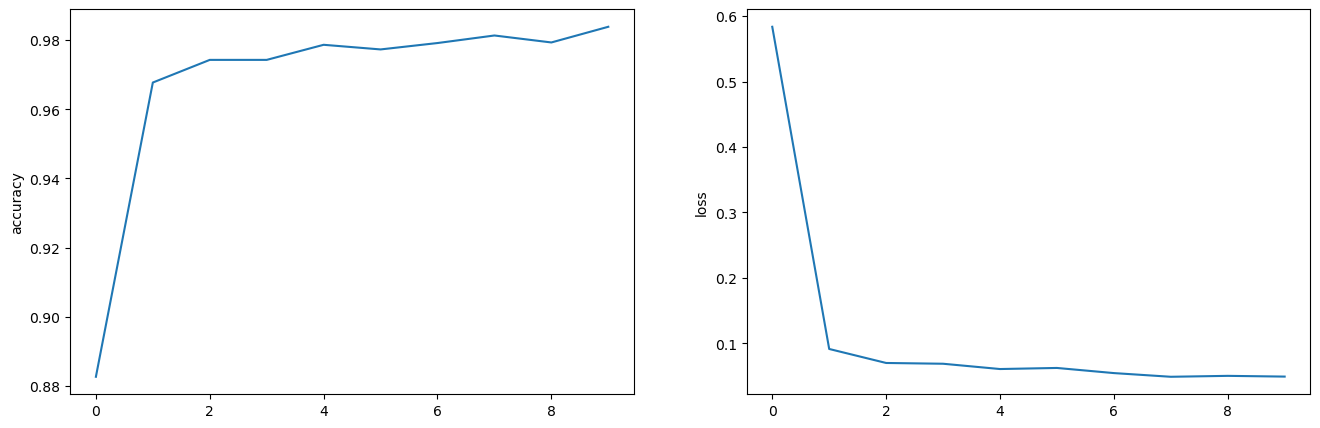



Evaluation:

172/172 [==============================] - 36s 211ms/step - loss: 0.0444 - accuracy: 0.9838
Loss: 0.04435858502984047
Accuracy: 0.9838005304336548


In [16]:
#Evaluating model
hist_df = pd.DataFrame(history.history) 
print(hist_df,'\n')
#Accuracy vs Epochs plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(ax=axes[0],data=hist_df, x=hist_df.index, y="accuracy")
sns.lineplot(ax=axes[1],data=hist_df, x=hist_df.index, y="loss")
plt.show()

print('\n\nEvaluation:\n')
score=model.evaluate(test_generator, batch_size=batch_size)
print(f'Loss: {score[0]}\nAccuracy: {score[1]}')

nres=(tuple(hist_df.iloc[-1,:2]),score)

In [17]:
#Saving model for the webapp
model.save('Classifier')

INFO:tensorflow:Assets written to: Classifier\assets


INFO:tensorflow:Assets written to: Classifier\assets
